In [3]:
import pyparax as parax
import numpy as np 
import pandas as pd
import scipy as sp
from math import pi
import matplotlib.pyplot as plt
import cmath
from scipy.optimize import leastsq

In [4]:
field_center = np.loadtxt('E_20.csv',delimiter=',',dtype=complex)

In [5]:
# Calculated center from expectation is 20,43
field_center = field_center[20-16:20+16,43-16:43+16]
field_center.shape

(32, 32)

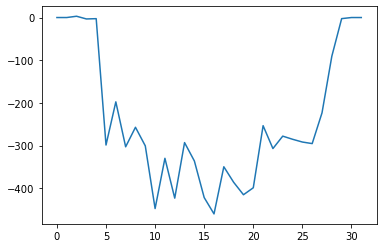

In [63]:
plt.plot(np.sum(np.unwrap(np.angle(field_center)),axis=1))

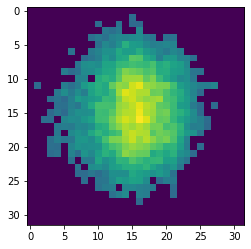

In [46]:
plt.imshow(np.angle(field_center))

In [6]:
lambda_= 1.3e-10
pitch = 3e-4/64
grid_dim = 32
window_extent = pitch*grid_dim

In [7]:
def param_se(pfit,pcov,x,y,function):
    err_f = lambda pfit,x,y:y-function(x,*pfit)
    var_res = np.sum((err_f(pfit,x,y))**2)/(len(y)-len(pcov))
    param_se = np.array([np.sqrt(pcov[i,i]*var_res) for i in range(len(pcov))])
    return param_se

def bootstrap_param_se(pfit,pcov,x,y,function):
    err_f = lambda pfit,x,y:y-function(x,*pfit)
    res_se = np.std(err_f(pfit,x,y))
    bootstrap_se_lst = []
    for i in range(100):
        y_random_err = np.random.normal(0,res_se,len(y))
        y_random = y+y_random_err
        random_fit,_ = leastsq(err_f,pfit,args=(x,y_random))
        bootstrap_se_lst.append(random_fit)
    param_se = np.std(np.array(bootstrap_se_lst),axis=0)
    return param_se


In [8]:
def get_amp_i_fit(marg_pmf,l,bootstrap):
    Ei = np.sum(marg_pmf*l)
    p0 = [1e-5,Ei,1e-5]
    pfit,pcov = leastsq(marg_residual,p0,args=(l,marg_pmf),full_output=1)[:2]
    if bootstrap:
        pse = bootstrap_param_se(pfit,pcov,l,marg_pmf,marg_fit)
    else:
        pse = param_se(pfit,pcov,l,marg_pmf,marg_fit)
        
    if np.all(pfit!=None):
        return pfit,pse
    else:
        return np.nan*np.ones(3),np.nan*np.ones(3)

def marg_residual(p,x,marg_pmf):
    A,x0,w = p
    marg_hat = marg_fit(x,A,x0,w)
    return marg_pmf - marg_hat

def marg_fit(x,A,x0,w):
    return A*np.exp(-(x-x0)**2/w**2)/w


In [9]:
def fit_astigmatic_field(fi,bootstrap):
    abs_fi = np.abs(fi)
    pmf = abs_fi/np.sum(abs_fi)
    fi_window_extent = window_extent*fi.shape[0]/grid_dim
    l = np.linspace(-fi_window_extent/2,fi_window_extent/2,fi.shape[0])
    marg_x = np.sum(pmf,axis=0)
    marg_y = np.sum(pmf,axis=1)
    pfit_amp_x,pse_amp_x = get_amp_i_fit(marg_x,l,bootstrap)
    pfit_amp_y,pse_amp_y = get_amp_i_fit(marg_y,l,bootstrap) 
    #Ex = np.sum(l*marg_x)
    #Ey = np.sum(l*marg_y)
    return pfit_amp_x,pse_amp_x,pfit_amp_y,pse_amp_y

def prop_astigmatic_fit(E,prop_len=20000,step_size=250,full_output=False,bootstrap=False):
    padded_dim = 4*grid_dim
    parax.numeric_parameters.wavelength=lambda_*1000
    parax.numeric_parameters.dx = 1000*window_extent/grid_dim
    parax.numeric_parameters.dy = 1000*window_extent/grid_dim
    parax.numeric_parameters.dz = step_size
    parax.numeric_parameters.N_x = padded_dim
    parax.numeric_parameters.N_y = padded_dim
    parax.numeric_parameters.N_z = prop_len//step_size
    f0 = 1j*np.zeros((padded_dim,padded_dim))
    center = E.reshape((grid_dim,grid_dim))
    f0[padded_dim//2-grid_dim//2:padded_dim//2+grid_dim//2,padded_dim//2-grid_dim//2:padded_dim//2+grid_dim//2] = center
    system = [prop_len]
    f = parax.experimental_simulator.experimental_simulator_2d.propagate(f0, system, output_full = True, forward = False, print_output=True)
    fit_amp_x_lst = []
    fit_amp_y_lst = []
    se_amp_x_lst = []
    se_amp_y_lst = []
    f_proper = []
    for i,fi in enumerate(f):
        fi_subset = fi[padded_dim//2-grid_dim//2:padded_dim//2+grid_dim//2,padded_dim//2-grid_dim//2:padded_dim//2+grid_dim//2]
        pfit_amp_x,pse_amp_x,pfit_amp_y,pse_amp_y = fit_astigmatic_field(fi_subset,bootstrap)
        fit_amp_x_lst.append(pfit_amp_x)
        fit_amp_y_lst.append(pfit_amp_y)
        se_amp_x_lst.append(pse_amp_x)
        se_amp_y_lst.append(pse_amp_y)
        f_proper.append(fi_subset)
    if full_output:
        return fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,f
    else:
        return fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst

In [10]:
fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,f = prop_astigmatic_fit(field_center.flatten(),bootstrap=True,full_output=True)

[['normal', 'normal']]
Propagate for 20000 units [mm]
Step 0/80
Step 1/80
Step 2/80
Step 3/80
Step 4/80
Step 5/80
Step 6/80
Step 7/80
Step 8/80
Step 9/80
Step 10/80
Step 11/80
Step 12/80
Step 13/80
Step 14/80
Step 15/80
Step 16/80
Step 17/80
Step 18/80
Step 19/80
Step 20/80
Step 21/80
Step 22/80
Step 23/80
Step 24/80
Step 25/80
Step 26/80
Step 27/80
Step 28/80
Step 29/80
Step 30/80
Step 31/80
Step 32/80
Step 33/80
Step 34/80
Step 35/80
Step 36/80
Step 37/80
Step 38/80
Step 39/80
Step 40/80
Step 41/80
Step 42/80
Step 43/80
Step 44/80
Step 45/80
Step 46/80
Step 47/80
Step 48/80
Step 49/80
Step 50/80
Step 51/80
Step 52/80
Step 53/80
Step 54/80
Step 55/80
Step 56/80
Step 57/80
Step 58/80
Step 59/80
Step 60/80
Step 61/80
Step 62/80
Step 63/80
Step 64/80
Step 65/80
Step 66/80
Step 67/80
Step 68/80
Step 69/80
Step 70/80
Step 71/80
Step 72/80
Step 73/80
Step 74/80
Step 75/80
Step 76/80
Step 77/80
Step 78/80
Step 79/80


/home/buzz/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


In [15]:
f.shape

(81, 128, 128)

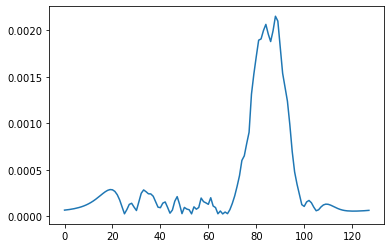

In [18]:
plt.plot(np.abs(f[int(4*13.5)][:,65]))

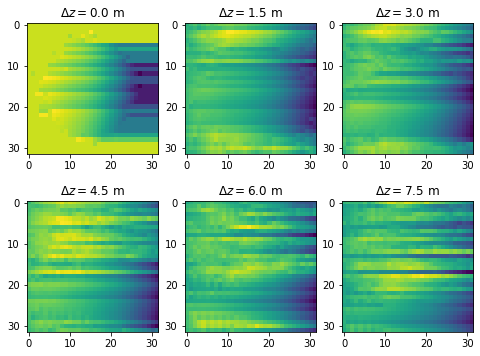

In [67]:
plt.figure(figsize=(8,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.unwrap(np.angle(f[i*6])))
    plt.title(f'$\Delta z = {i*6*0.25}$ m')

In [112]:
from scipy.ndimage import convolve
a = [1,2,2,0,0,0]
b = [1,2,3,4,0,0]
np.roll(convolve(a,b,mode='wrap'),3)

array([ 1,  4,  9, 14, 14,  8])

In [108]:
a = [1,2,2]
b = [1,2,3,4]
np.convolve(b,a)

array([ 1,  4,  9, 14, 14,  8])

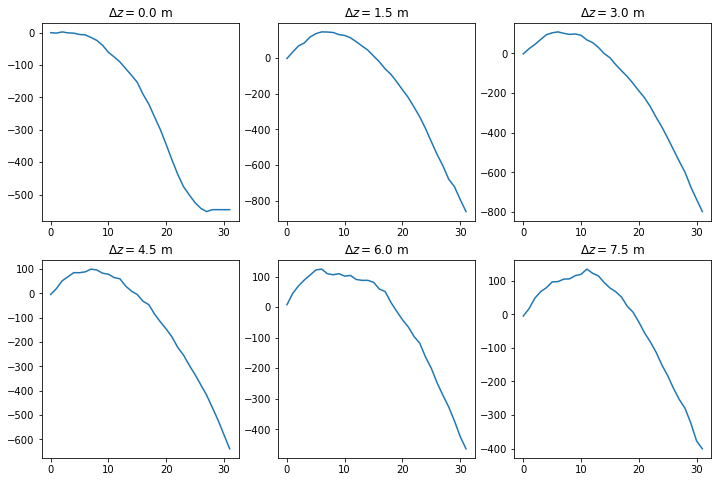

In [71]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(np.sum(np.unwrap(np.angle(f[i*6])),axis=1))
    plt.title(f'$\Delta z = {i*6*0.25}$ m')


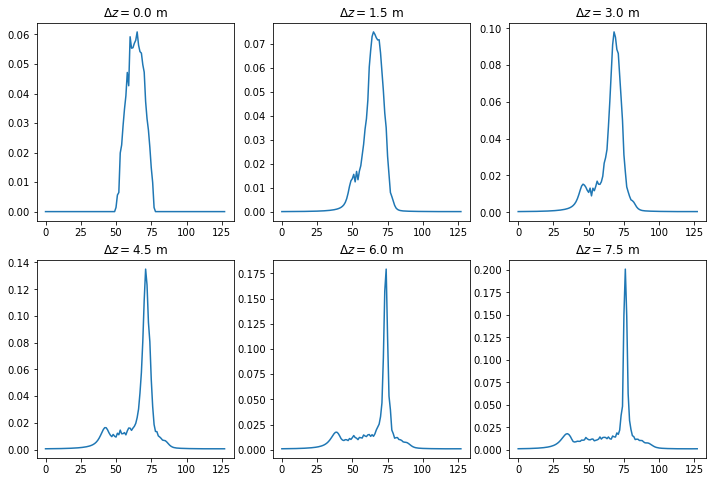

In [16]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(np.sum(np.abs(f[i*6]),axis=1))
    plt.title(f'$\Delta z = {i*6*0.25}$ m')


In [49]:
def wz_fit(z,w0,z0,wavelen):
    zR = pi*w0**2/wavelen
    return w0*(1+((z-z0)/zR)**2)**0.5

def wz_residual(p,z,w):
    w0,z0,wavelen = p
    w_hat = wz_fit(z,w0,z0,wavelen)
    return w-w_hat

def get_w0(w_arr,full_output=False,step_size=250,bootstrap=False):
    z = [i*step_size/1000 for i,w in enumerate(w_arr) if np.logical_not(np.isnan(w))]
    w = w_arr[np.logical_not(np.isnan(w_arr))]
    p0 = [0.01,30,lambda_]
    pfit,pcov = leastsq(wz_residual,p0,args=(z,w),full_output=1)[:2]
    if bootstrap:
        pse = bootstrap_param_se(pfit,pcov,z,w,wz_fit)
    else:
        pse = param_se(pfit,pcov,z,w,wz_fit)
    if full_output:
        plt.plot(z,np.abs(w))
        plt.plot(z,wz_fit(z,*pfit))
        plt.xlabel('$\Delta z$ (m)')
        plt.ylabel('$w(z)$ (m)')
        return pfit,pse
    else:
        return pfit,pse
    

Text(0, 0.5, '$w_x(z)$ (m)')

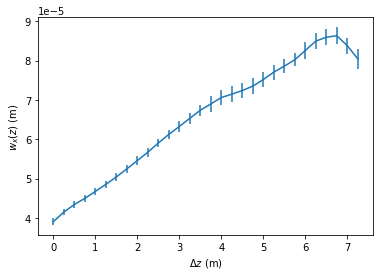

In [13]:
plt.errorbar(250/1000*np.arange(len(fit_amp_x_lst))[:30],np.array(fit_amp_x_lst)[:30,2],yerr=np.array(se_amp_x_lst)[:30,2])
plt.xlabel('$\Delta z$ (m)')
plt.ylabel('$w_x(z)$ (m)')

Text(0, 0.5, '$w_y(z)$ (m)')

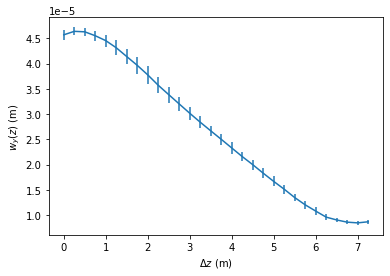

In [14]:
plt.errorbar(250/1000*np.arange(len(fit_amp_y_lst))[:30],np.array(fit_amp_y_lst)[:30,2],yerr=np.array(se_amp_y_lst)[:30,2])
plt.xlabel('$\Delta z$ (m)')
plt.ylabel('$w_y(z)$ (m)')

w0y = 8.405950822902846e-06 , z0y = 5.426230790035571 , wavelen = 1.961307813899892e-10


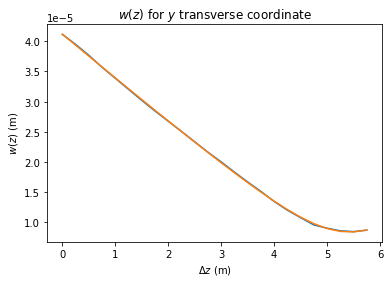

In [52]:
fit_w0y, se_w0y = get_w0(np.array(fit_amp_y_lst)[6:30,2],bootstrap=True,full_output=True)
plt.title('$w(z)$ for $y$ transverse coordinate')
w0y,z0y,wavelen = fit_w0y
print('w0y =',w0y, ', z0y =',z0y,  ', wavelen =',wavelen)

At the same distance with $N_F=0.125 \implies $

In [166]:
# End of propagation
z = 2*28*pitch**2/lambda_
# Full propagation dictates shortest z is 2 if we choose step size 2000
#z = 1
z

9.46514423076923

In [167]:
N_F = (window_extent/2)**2/(lambda_*z)
N_F

3.5

In [174]:
M = 90
Q = M/(4*N_F)
Q

6.428571428571429

In [175]:
N = Q*M
N

578.5714285714286

According to Fig. 5.5 in Goodman, we should go for $grid\_dim = 90$, which is the adjustment to using $M$, for aliasing of $0.01$ the peak value at the edges. That means we need a spline to adjust sampling.  As we see in the image below though, this grid $28x28$ isn't really the full extent of the actual samples since it's actually zero padded.  That may result in some additional aliasing with the spectral island being actually larger in reality

Text(0.5, 1.0, 'amp')

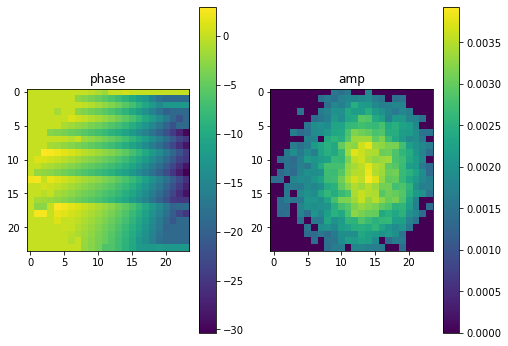

In [155]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(np.unwrap(np.angle(field_center[2:-2,1:-3])))
plt.title('phase')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.abs(field_center[2:-2,1:-3]))
plt.colorbar()
plt.title('amp')

In [149]:
field_center = field_center[2:-2,1:-3]

In [156]:
window_extent = pitch*field_center.shape[0]

In [157]:
from scipy.interpolate import interp2d
# have to separately interpolate amplitude and phase
x = np.linspace(-window_extent/2,window_extent/2,field_center.shape[0])
y = x
u_spline_amp = interp2d(x,y,np.abs(field_center),kind='cubic')
u_spline_phase = interp2d(x,y,np.unwrap(np.angle(field_center)),kind='cubic')

In [177]:
x_M = np.linspace(-window_extent/2,window_extent/2,M)
y_M = x_M
field_center_abs = u_spline_amp(x_M,y_M)
field_center_phase = u_spline_phase(x_M,y_M)

In [179]:
field_center_abs.shape,field_center_phase.shape

((90, 90), (90, 90))

Text(0.5, 1.0, 'amp')

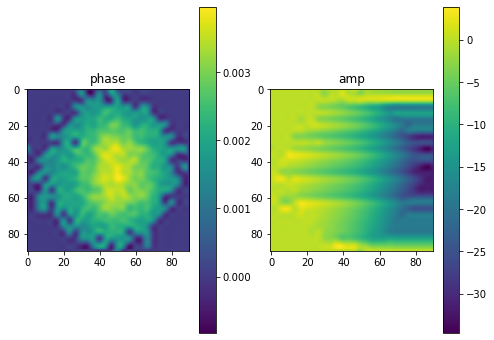

In [178]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(field_center_abs)
plt.title('phase')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(field_center_phase)
plt.colorbar()
plt.title('amp')

In [ ]:
fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,f = prop_astigmatic_fit(field_center.flatten(),bootstrap=True,full_output=True)